# Валидация данных и оценка модели

## Валидация данных. Методы валидации


Будем решать задачу классификации: классифицировать воду на пригодную и не пригодную для питья на основе её химического состава.

In [33]:
#Импортируем необходимые модули

#Для матричных вычислений
import numpy as np 
#Для анализа и предобработки данных
import pandas as pd
#Для визуализации
import matplotlib.pyplot as plt 
import seaborn as sns

#Метрики
from sklearn import metrics
#Методы разделения и валидации
from sklearn import model_selection

#Линейные модели 
from sklearn import linear_model
#Деревья решений
from sklearn import tree
#Стиль отрисовки seaborn 
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [34]:
#Загрузим наши данные
water_data = pd.read_csv('data/water_potability.csv')
display(water_data.head())

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [35]:
#Выведем информацию о пропусках в данных в процентном соотношении
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [36]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')
                                           ['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')
                                           ['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')
                                           ['Trihalomethanes'].transform('median'))

In [37]:
#Убедимся в отсутствии пропусков
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [38]:
#Разделим набор данных на матрицу наблюдений 
#и вектор правильных ответов
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

### Основные методы валидации данных

### HOLD-OUT
Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).


Реализация метода в sklearn

In [39]:
#Пример разбиения данных
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, 
                                                                      y, 
                                                                      test_size=0.2,
                                                                      random_state=42)

In [40]:
#Проверим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Test shape: (656, 9)


В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [41]:
#Создаем модель 
model = tree.DecisionTreeClassifier(
    #Критерий информативности
    criterion='entropy',
    #Максимальная глубина
    max_depth=7,
    #Минимальное число объектов в листе
    min_samples_leaf=5,
    #Генератор случайных чисел
    random_state=42
)

#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

#Делаем предсказание на каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

#Выводим значение метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10

In [42]:
#Разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2,
                                                                      random_state=42)
#Разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5,
                                                                    random_state=42)

In [43]:
#Выводим размерности 
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


### K-FOLD
Реализация метода в sklearn

In [44]:
#Создаем модель
model = tree.DecisionTreeClassifier(
    #Критерий информативности
    criterion='entropy',
    #Максимальная глубина 
    max_depth=7,
    #Минимальное число объектов в листе
    min_samples_leaf=5,
    #Генератор случайных чисел
    random_state=42
)

#Создаем объект кросс-валидации KFold
kf = model_selection.KFold(n_splits=5)
#Создаем список хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс валидации (используем весь набор данных)
#train_index - индексы тренировочный выборки
#valid_index - индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим ее в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [45]:
#Выведем содержимое массивов train_metrics и val_metrics
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [46]:
#Для агрегированной оценки рассчитаем среднее значение метрик
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


In [47]:
#Итоговый код с использованием функции cross_validate()

#Создаем модель
model = tree.DecisionTreeClassifier(
    #Критерий информативности
    criterion='entropy',
    #Максимальная глубина 
    max_depth=7,
    #Минимальное число объектов в листе
    min_samples_leaf=5,
    #Генератор случайных чисел
    random_state=42
)

#Создаем объект кросс-валидации KFold
kf = model_selection.KFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    #Модель
    estimator=model,
    #Матрица наблюдений X
    X=X,
    #Вектор ответов y
    y=y,
    #Кросс-валидатор
    cv=kf,
    #Метрика
    scoring='accuracy',
    #Подсчет метрики на тренировочных фолдах
    return_train_score=True
)
display(cv_metrics)

{'fit_time': array([0.02900624, 0.0260067 , 0.0300076 , 0.02300429, 0.02300429]),
 'score_time': array([0.00300097, 0.00299978, 0.00200033, 0.00300288, 0.0030036 ]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [48]:
#Рассчитаем среднее значение
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### LEAVE-ONE-OUT
Реализация метода в sklearn

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

In [49]:
#Создаем модель
model = tree.DecisionTreeClassifier(
    #Критерий информативности
    criterion='entropy',
    #Максимальная глубина 
    max_depth=7,
    #Минимальное число объектов в листе
    min_samples_leaf=5,
    #Генератор случайных чисел
    random_state=42
)

#Создаем объект кросс-валидации KFold
loo = model_selection.LeaveOneOut()

#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    #Модель
    estimator=model,
    #Матрица наблюдений X
    X=X.iloc[:500],
    #Вектор ответов y
    y=y.iloc[:500],
    #Кросс-валидатор
    cv=loo,
    #Метрика
    scoring='accuracy',
    #Подсчет метрики на тренировочных фолдах
    return_train_score=True
)
#Рассчитаем среднее значение
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


In [50]:
#Сделаем тоже самое, но не будем срезать данные
#Создаем модель
model = tree.DecisionTreeClassifier(
    #Критерий информативности
    criterion='entropy',
    #Максимальная глубина 
    max_depth=7,
    #Минимальное число объектов в листе
    min_samples_leaf=5,
    #Генератор случайных чисел
    random_state=42
)

#Создаем объект кросс-валидации KFold
loo = model_selection.LeaveOneOut()

#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    #Модель
    estimator=model,
    #Матрица наблюдений X
    X=X,
    #Вектор ответов y
    y=y,
    #Кросс-валидатор
    cv=loo,
    #Метрика
    scoring='accuracy',
    #Подсчет метрики на тренировочных фолдах
    return_train_score=True
)
#Рассчитаем среднее значение
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.76


## Дисбаланс выборки
Рассмотрим влияние дисбаланса на примере датасета о качестве воды


Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

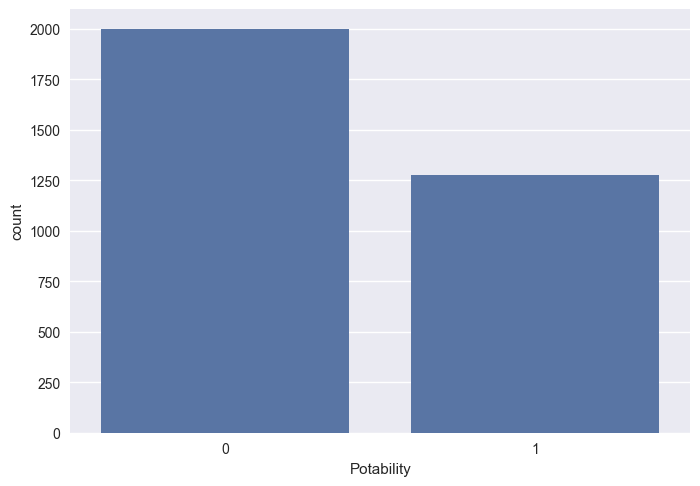

In [52]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

### Стратифицированное разбиение

Для начала проводем обычное случайное разбиение на тренировочную и валидационную выборку без стратифицирования при помощи train_test_split()

In [53]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train: \n', y_train.value_counts(normalize=True), sep='')
print('Valid: \n', y_valid.value_counts(normalize=True), sep='')

Train: 
Potability
0    0.620229
1    0.379771
Name: proportion, dtype: float64
Valid: 
Potability
0    0.568598
1    0.431402
Name: proportion, dtype: float64


Теперь, передадим параметр stratify

In [54]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train: \n', y_train.value_counts(normalize=True), sep='')
print('Valid: \n', y_valid.value_counts(normalize=True), sep='')

Train: 
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid: 
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [55]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train: \n', y_train.value_counts(normalize=True), sep='')
    print('Valid: \n', y_valid.value_counts(normalize=True), sep='')
    print('-' * 40)

Train: 
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid: 
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train: 
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid: 
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train: 
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid: 
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


### Задание 3.3

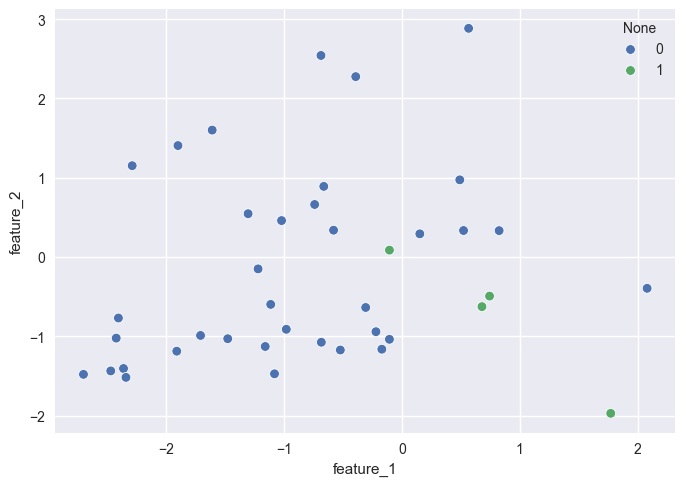

In [70]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

### Выбор метрик в условиях дисбаланса классов

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [72]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаем модель
model = tree. DecisionTreeClassifier(
    #Критерий информативности
    criterion='entropy',
    #Максимальная глубина
    max_depth=7,
    #Минимальное число объектов в листе
    min_samples_leaf=5,
    #Генератор случайных чисел
    random_state=42
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значение метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



### Задание 3.5

In [79]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

 #Вызываем модель логистической регрессии
log_reg = linear_model.LogisticRegression()
 #Обучаем модель логистической регрессии
log_reg.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = log_reg.predict(X_train)
y_valid_pred = log_reg.predict(X_valid)
#Выводим значение метрик
print(metrics.classification_report(y_valid, y_valid_pred))


              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



### Задание 3.6

In [80]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Program Files (x86)\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


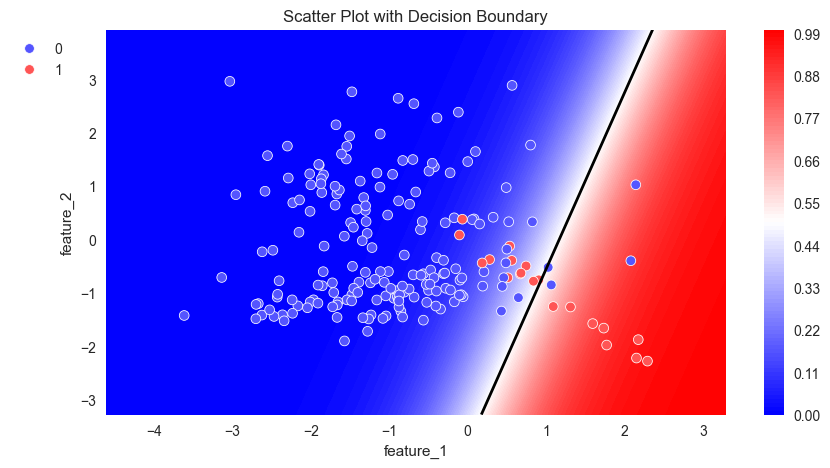

In [83]:
plot_probabilities_2d(X, y, log_reg);

### Построение модели в условиях дисбаланса классов